# Analyse Morris results

In [32]:
import pandas as pd
import seaborn as sns
import re

Run with `dakota -i morris_lt.in > morris_summary.out`: only `>` gets results written to file.

In [33]:
# Must be am easier way to get Dakota results out? Apparently not
# Read in .out file (contains summary results)
output_files = ["morris_lt_summary.out", "morris_lt_max_net_elec_summary.out"]

# Match line in output
input_re = re.compile(r"Input\s+(\d+)\s.*=\s+(\d+\.\d+e[+-]\d+)\s+(\d+\.\d+e[+-]\d+)")
end_of_results_re = re.compile(r"^$")
results = {"design": [], "input": [], "descriptor": [], "mod_mean": [], "std": []}

# Morris OAT in Dakota doesn't provide descriptors for each param: only
# "Input 1" etc. in summary output
# This descriptor list is in same order as input file continuous design descriptors
# Only way of matching the two apparently
descriptors = [
    "fdene",
    "hfact",
    "coreradius",
    "fimp_2",
    "fimp_14",
    "psepbqarmax",
    "flhthresh",
    "cboot",
    "peakfactrad",
    "kappa",
    "etaech",
    "feffcd",
    "etath",
    "etaiso",
    "boundl_18",
    "pinjalw",
    "alstroh",
    "sig_tf_wp_max",
    "aspect",
    "boundu_2",
    "triang",
]

# Find the first set of summary results in .out file, which corresponds to w
# Subsequent summary results correspond to individual constraints
# Due to ordering of responses in .in file
for output_file in output_files:
    design_and_suffix = output_file.split("morris_")[1]
    design = design_and_suffix.split("_summary.out")[0]
    with open(output_file, "r") as f:
        content = f.readlines()

    got_results = False
    for line in content:
        if matches := input_re.match(line):
            got_results = True
            # Start of results
            results["design"].append(design)
            results["input"].append(int(matches[1]))
            # "Input 1" is descriptor[0]
            results["descriptor"].append(descriptors[int(matches[1]) - 1])
            results["mod_mean"].append(float(matches[2]))
            results["std"].append(float(matches[3]))
        elif got_results and end_of_results_re.match(line):
            # Got first set of results (w), ignore others (individual constraints), now exit
            break
        else:
            # Not reached results in file yet
            continue

results_df = pd.DataFrame(results)
results_df

,design,input,descriptor,mod_mean,std
0,lt,1,fdene,0.000000,0.000000
1,lt,2,hfact,0.000000,0.000000
2,lt,3,coreradius,0.000000,0.000000
3,lt,4,fimp_2,0.000000,0.000000
4,lt,5,fimp_14,1.268900,1.427500
5,lt,6,psepbqarmax,0.000000,0.000000
6,lt,7,flhthresh,0.360530,0.476360
7,lt,8,cboot,0.250530,0.635130
8,lt,9,peakfactrad,0.000000,0.000000
9,lt,10,kappa,0.462870,0.776980


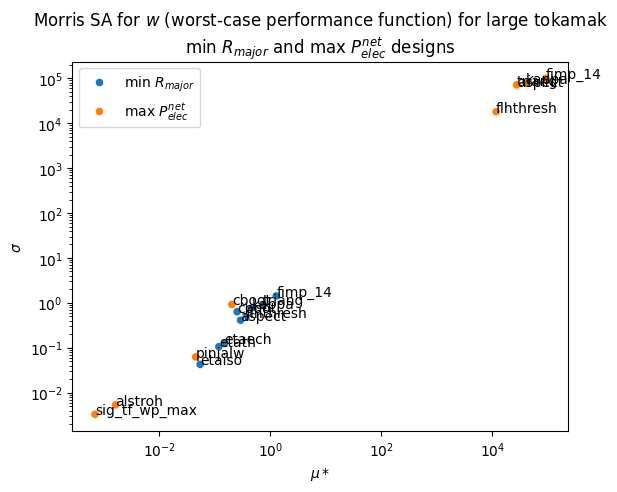

In [34]:
# Plot both designs together
ax = sns.scatterplot(data=results_df, x="mod_mean", y="std", hue="design")


def label_point(df):
    others = False
    for _, row in df.iterrows():
        mod_mean = row["mod_mean"]
        std = row["std"]
        # Only label if not 0: avoid overwriting at same point
        if mod_mean != 0.0 and std != 0.0:
            ax.annotate(text=row["descriptor"], xy=(mod_mean, std))
        elif others is False:
            ax.annotate(text="Other", xy=(mod_mean, std))
            others = True


ax.loglog()
label_point(results_df)
ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for large tokamak\nmin $R_{major}$"
    " and max $P_{elec}^{net}$ designs"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

label_map = {"lt": "min $R_{major}$", "lt_max_net_elec": "max $P_{elec}^{net}$"}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [label_map[l] for l in labels])

Text(0, 0.5, '$\\sigma$')

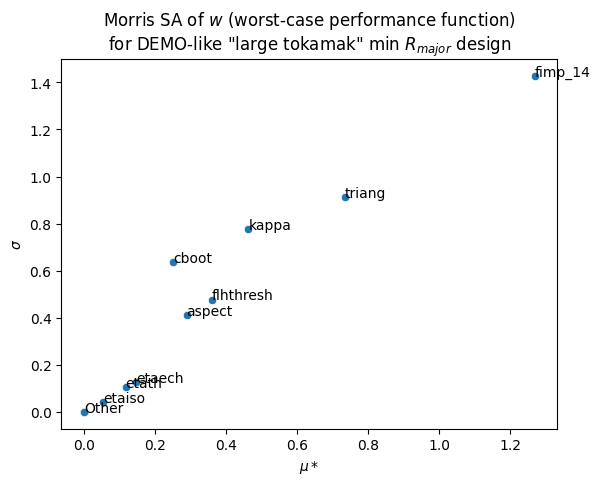

In [35]:
# min rmajor only
lt_results_df = results_df[results_df["design"] == "lt"]
ax = sns.scatterplot(data=lt_results_df, x="mod_mean", y="std")
label_point(lt_results_df)
ax.set_title(
    "Morris SA of $w$ (worst-case performance function)\n"
    'for DEMO-like "large tokamak" min $R_{major}$ design'
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

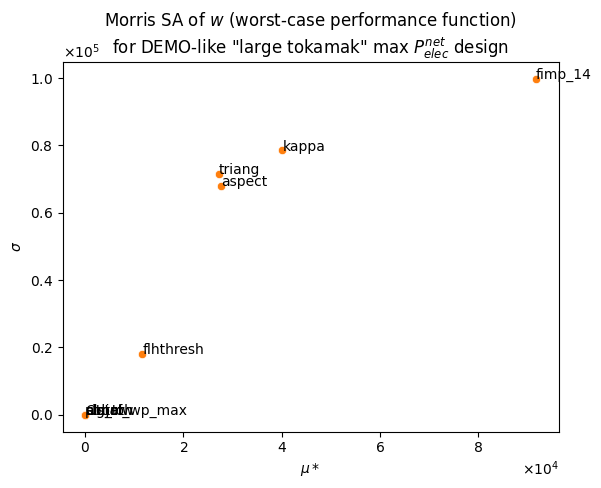

In [41]:
# Max P net elec only
lt_max_net_elec_results_df = results_df[results_df["design"] == "lt_max_net_elec"]
ax = sns.scatterplot(data=lt_max_net_elec_results_df, x="mod_mean", y="std", color="C1")
label_point(lt_max_net_elec_results_df)
ax.set_title(
    'Morris SA of $w$ (worst-case performance function)\nfor DEMO-like "large tokamak" max $P_{elec}^{net}$ design'
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")
ax.ticklabel_format(style="sci", scilimits=(0, 0), useMathText=True)

## Individual constraint analysis

In [37]:
# Read in individual evaluations
# evals = pd.read_csv("morris_lt.dat", sep="\s+")
# evals_described = evals.describe()
# evals_w_sorted = evals.sort_values(by="w", ascending=False)
# Nothing too badly violated

evals = pd.read_csv("morris_lt_max_net_elec.dat", sep="\s+")
# Drop interface column; str and not useful
evals.drop(labels="interface", axis=1, inplace=True)

# Describe responses
responses_re = r"(^w$|eq_con\d{3})"
parameters_re = r"^(?!(w$|\w*eq_con\d{3}))"
responses = evals.filter(regex=responses_re)
responses.describe()

,w,eq_con001,eq_con002,eq_con011,ineq_con005,ineq_con008,ineq_con009,ineq_con013,ineq_con015,ineq_con030,...,ineq_con035,ineq_con036,ineq_con060,ineq_con062,ineq_con065,ineq_con072,ineq_con081,ineq_con068,ineq_con031,ineq_con032
count,506.000000,506.000000,506.000000,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,...,5.060000e+02,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,506.000000
mean,51112.506722,-0.003802,0.012701,5.062617e-14,-0.003353,-0.361570,-0.010294,0.058699,51112.462322,-1.487501,...,6.198942e-10,-1.496836e-01,0.004484,0.043220,-2.105665,-0.000028,-0.672948,-56933.667452,-1.419900e-10,-0.156537
std,64343.503131,0.011199,0.021997,6.317133e-30,0.040716,0.031724,0.019892,0.077514,64343.538470,0.201240,...,1.034999e-25,2.778304e-17,0.002078,0.032734,0.025884,0.000701,0.091190,71784.187539,2.587497e-26,0.000000
min,0.016801,-0.019515,-0.029159,5.062617e-14,-0.054914,-0.408311,-0.039953,-0.084183,-0.205706,-1.666667,...,6.198942e-10,-1.496836e-01,0.001912,-0.018128,-2.140465,-0.000964,-0.790011,-155025.531000,-1.419900e-10,-0.156537
25%,0.194874,-0.014837,-0.002670,5.062617e-14,-0.054914,-0.388587,-0.025388,0.006899,0.194874,-1.666667,...,6.198942e-10,-1.496836e-01,0.002356,0.009217,-2.140465,-0.000964,-0.790011,-144370.786600,-1.419900e-10,-0.156537
50%,2.158194,-0.004983,0.016443,5.062617e-14,-0.017586,-0.360787,-0.008759,0.064448,2.158194,-1.509575,...,6.198942e-10,-1.496836e-01,0.005548,0.051616,-2.093684,0.000286,-0.637849,-2.569589,-1.419900e-10,-0.156537
75%,131792.840900,0.007981,0.032229,5.062617e-14,0.047855,-0.331397,0.007603,0.119963,131792.840900,-1.234801,...,6.198942e-10,-1.496836e-01,0.006918,0.080176,-2.074946,0.000811,-0.559513,-0.295724,-1.419900e-10,-0.156537
max,132474.901200,0.012820,0.047509,5.062617e-14,0.047855,-0.312750,0.021502,0.175071,132474.901200,-1.186164,...,6.198942e-10,-1.496836e-01,0.006918,0.083372,-2.074946,0.000811,-0.559513,0.172501,-1.419900e-10,-0.156537


Looks like `ineq_con015` is the one with the huge violation value. Find programmatically:

In [38]:
# Find constraint that is w (worst violated)
print(
    "Worst-violated constraint: "
    # Returns [w, constraint_name]
    + responses.columns[responses.eq(responses["w"].max()).any(axis=0)][1]
    + " = "
    + str(responses["w"].max())
)

# Find parameters causing max w
# Find rows containing max w, then filter for parameter columns only
max_w_rows = evals[responses.eq(responses["w"].max()).any(axis=1)].filter(
    regex=parameters_re
)
# Which parameters are staying constant?
# eyeballing: fimp_14 and triang always look similar in max w case
# Use mean-normalised std
max_w_rows.loc[:, max_w_rows.std() / max_w_rows.mean() < 0.01].describe()
max_w_rows.loc[:, max_w_rows.std() / max_w_rows.mean() < 0.01]

Worst-violated constraint: ineq_con015 = 132474.9012


,fimp_14,triang
16,0.0001,0.4
17,0.0001,0.4
18,0.0001,0.4
19,0.0001,0.4
20,0.0001,0.4
21,0.0001,0.4
74,0.0001,0.4
75,0.0001,0.4
76,0.0001,0.4
77,0.0001,0.4


High fimp_14 and low triang cause the max w value (high constraint violation). Check row 16 (run 17 in Dakota). Constraint 15 ~1e5. What causes this? `con15 = plhthresh / pdivt`:
```
(plhthresh)___________________      1.3247590122539455E+02 OP
(pdivt)_______________________      1.0000000000000000E-03 OP
```
plhthresh is reasonable (131 MW), but pdivt is very low. Currently resting on a kludge to keep positive. This is the reason for high violation of constraint 15, and hence high $w$.